# **Customer LifeTime Value Prediction**

Customer lifetime value is the total worth to a business of a customer over the whole period of their relationship. It’s an important metric as it costs less to keep existing customers than it does to acquire new ones, so increasing the value of your existing customers is a great way to drive growth

To calculate **Lifetime Value** first we need to select a time window. 

By the equation below, we can have Lifetime Value for each customer in that specific time window:

Lifetime Value: Total Gross Revenue - Total Cost

In [64]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import scale

from sklearn.metrics import classification_report,confusion_matrix

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold, cross_val_score, train_test_split

import plotly.graph_objects as go

In [2]:
df = pd.read_csv('/content/Brazilian_dataset_EDA_Clustering.csv')

**Feature Extraction**

In [4]:
#converting the type of Invoice Date Field from string to datetime.
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [5]:
df_6m = df[(df.order_purchase_timestamp >= pd.to_datetime('2017-6-1')) & (df.order_purchase_timestamp  < pd.to_datetime('2017-12-1'))].reset_index(drop=True)

In [ ]:
df_6m.head()

In [8]:
#calculate revenue and create a new dataframe for it
df_6m['Revenue'] = df_6m['price'] * df_6m['order_item_id']
orders_user_6m = df_6m.groupby('customer_unique_id')['Revenue'].sum().reset_index()
orders_user_6m.columns = ['customer_unique_id','m6_Revenue']


#plot LTV histogram
plot_data = [
    go.Histogram(
        x=orders_user_6m.query('m6_Revenue < 10000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()


In [50]:
df_classification = df[['recency', 'frequency', 'monetary', 'r_quartile', 'f_quartile', 'm_quartile', 'RFM_Score_s', 'clusters', 'customer_unique_id','RFM_Level']]

In [51]:
df_classification = pd.merge(df_classification, orders_user_6m, on='customer_unique_id', how='left')
df_classification = df_classification.fillna(0)

In [52]:
df_classification

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score_s,clusters,customer_unique_id,RFM_Level,m6_Revenue
0,335.0,2.0,62.23,2.0,1.0,2.0,5.0,4.0,7c396fd4830fd04220f754e42b4e5bff,Promising,29.99
1,383.0,1.0,37.77,1.0,1.0,1.0,3.0,1.0,3a51803cc0d012c3b5dc8b7528cb05f7,Require Activation,29.99
2,396.0,1.0,37.77,1.0,1.0,1.0,3.0,1.0,ef0996a1a279c26e7ecbd737be23d235,Require Activation,29.99
3,314.0,1.0,44.09,2.0,1.0,1.0,4.0,1.0,e781fdcc107d13d865fc7698711cc572,Needs Attention,29.99
4,282.0,1.0,356.12,2.0,1.0,4.0,7.0,3.0,3e4fd73f1e86b135b9b121d6abbe9597,Loyal,339.00
...,...,...,...,...,...,...,...,...,...,...,...
13934,229.0,1.0,74.16,2.0,1.0,2.0,5.0,4.0,4f698409ab0340170a16822f03a1411c,Promising,0.00
13935,320.0,1.0,337.27,2.0,1.0,4.0,7.0,3.0,cadfd65da64dd51f3f445921f3540012,Loyal,249.90
13936,434.0,1.0,75.07,1.0,1.0,2.0,4.0,1.0,934413f76823331fd8c6d6d9958f0631,Needs Attention,59.90
13937,516.0,1.0,76.02,1.0,1.0,2.0,4.0,1.0,8d60a4803f5cf4a4275d5b69009e0e4b,Needs Attention,0.00


In [53]:
df_graph = df_classification.query("m6_Revenue < 60000")

plot_data = [
    go.Scatter(
        x=df_graph.query("clusters == 0.0")['RFM_Score_s'],
        y=df_graph.query("clusters == 0.0")['m6_Revenue'],
        mode='markers',
        name='Cluster-0',
        marker= dict(size= 8,
            line= dict(width=1),
            color= 'blue',
           )
    ),
        go.Scatter(
        x=df_graph.query("clusters == 1.0")['RFM_Score_s'],
        y=df_graph.query("clusters == 1.0")['m6_Revenue'],
        mode='markers',
        name='Cluster-1',
        marker= dict(size= 8,
            line= dict(width=1),
            color= 'green',
           )
    ),
        go.Scatter(
        x=df_graph.query("clusters == 2.0")['RFM_Score_s'],
        y=df_graph.query("clusters == 2.0")['m6_Revenue'],
        mode='markers',
        name='Cluster-2',
        marker= dict(size= 8,
            line= dict(width=1),
            color= 'red',
           )
    ),
        go.Scatter(
        x=df_graph.query("clusters == 3.0")['RFM_Score_s'],
        y=df_graph.query("clusters == 3.0")['m6_Revenue'],
        mode='markers',
        name='Cluster-3',
        marker= dict(size= 8,
            line= dict(width=1),
            color= 'yellow',
           )
    ),
        go.Scatter(
        x=df_graph.query("clusters == 4.0")['RFM_Score_s'],
        y=df_graph.query("clusters == 4.0")['m6_Revenue'],
        mode='markers',
        name='Cluster-4',
        marker= dict(size= 8,
            line= dict(width=1),
            color= 'black',
           )    
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [54]:
#remove outliers
df_classification = df_classification[df_classification['m6_Revenue']<df_classification['m6_Revenue'].quantile(0.99)]

from sklearn.cluster import KMeans

#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_classification[['m6_Revenue']])
df_classification['LTVCluster'] = kmeans.predict(df_classification[['m6_Revenue']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
df_classification.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,11107.0,1.602906,6.241915,0.0,0.0,0.000,0.00,37.0
1,715.0,198.154210,61.043948,135.9,149.9,174.920,238.99,359.0
2,1976.0,73.139185,25.281781,37.4,55.0,60.085,89.90,135.0


**Feature Correlation**

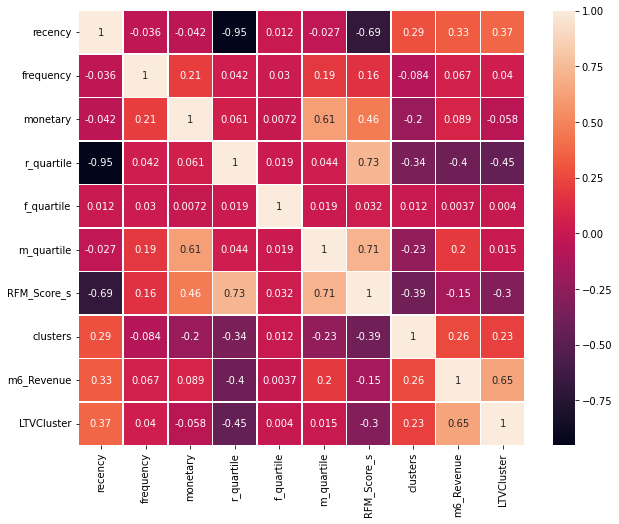

In [56]:
#calculate and show correlations
corr_matrix = df_classification.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot = True, linewidths=.5, ax = ax)

**Training and Testing data**

In [58]:
#create X and y, X will be feature set and y is the label - LTV
X = df_classification.drop(['LTVCluster','m6_Revenue', 'customer_unique_id'],axis=1)
X = pd.get_dummies(X)
y = df_classification['LTVCluster']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

### **MullerLoop**

In [62]:
names = ["XGBClassifier", "Random Forest", "Decision Tree", "AdaBoost", "MLP Classifier"]

In [65]:
classifier = [
    xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    DecisionTreeClassifier(max_depth=5),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=1000)]

In [66]:
max_score = 0.0
max_class = ''
# iterate over classifiers
for name, clf in zip(names, classifier):
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Regressor = %s, Score (test, accuracy) = %.2f,' %(name, score))
    
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Regressor = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

Regressor = XGBClassifier, Score (test, accuracy) = 95.94,
Regressor = Random Forest, Score (test, accuracy) = 90.58,
Regressor = Decision Tree, Score (test, accuracy) = 96.09,
Regressor = AdaBoost, Score (test, accuracy) = 96.38,
Regressor = MLP Classifier, Score (test, accuracy) = 90.43,
--------------------------------------------------------------------------------
Best --> Regressor = AdaBoost, Score (test, accuracy) = 96.38
